# **Agentic RAG**


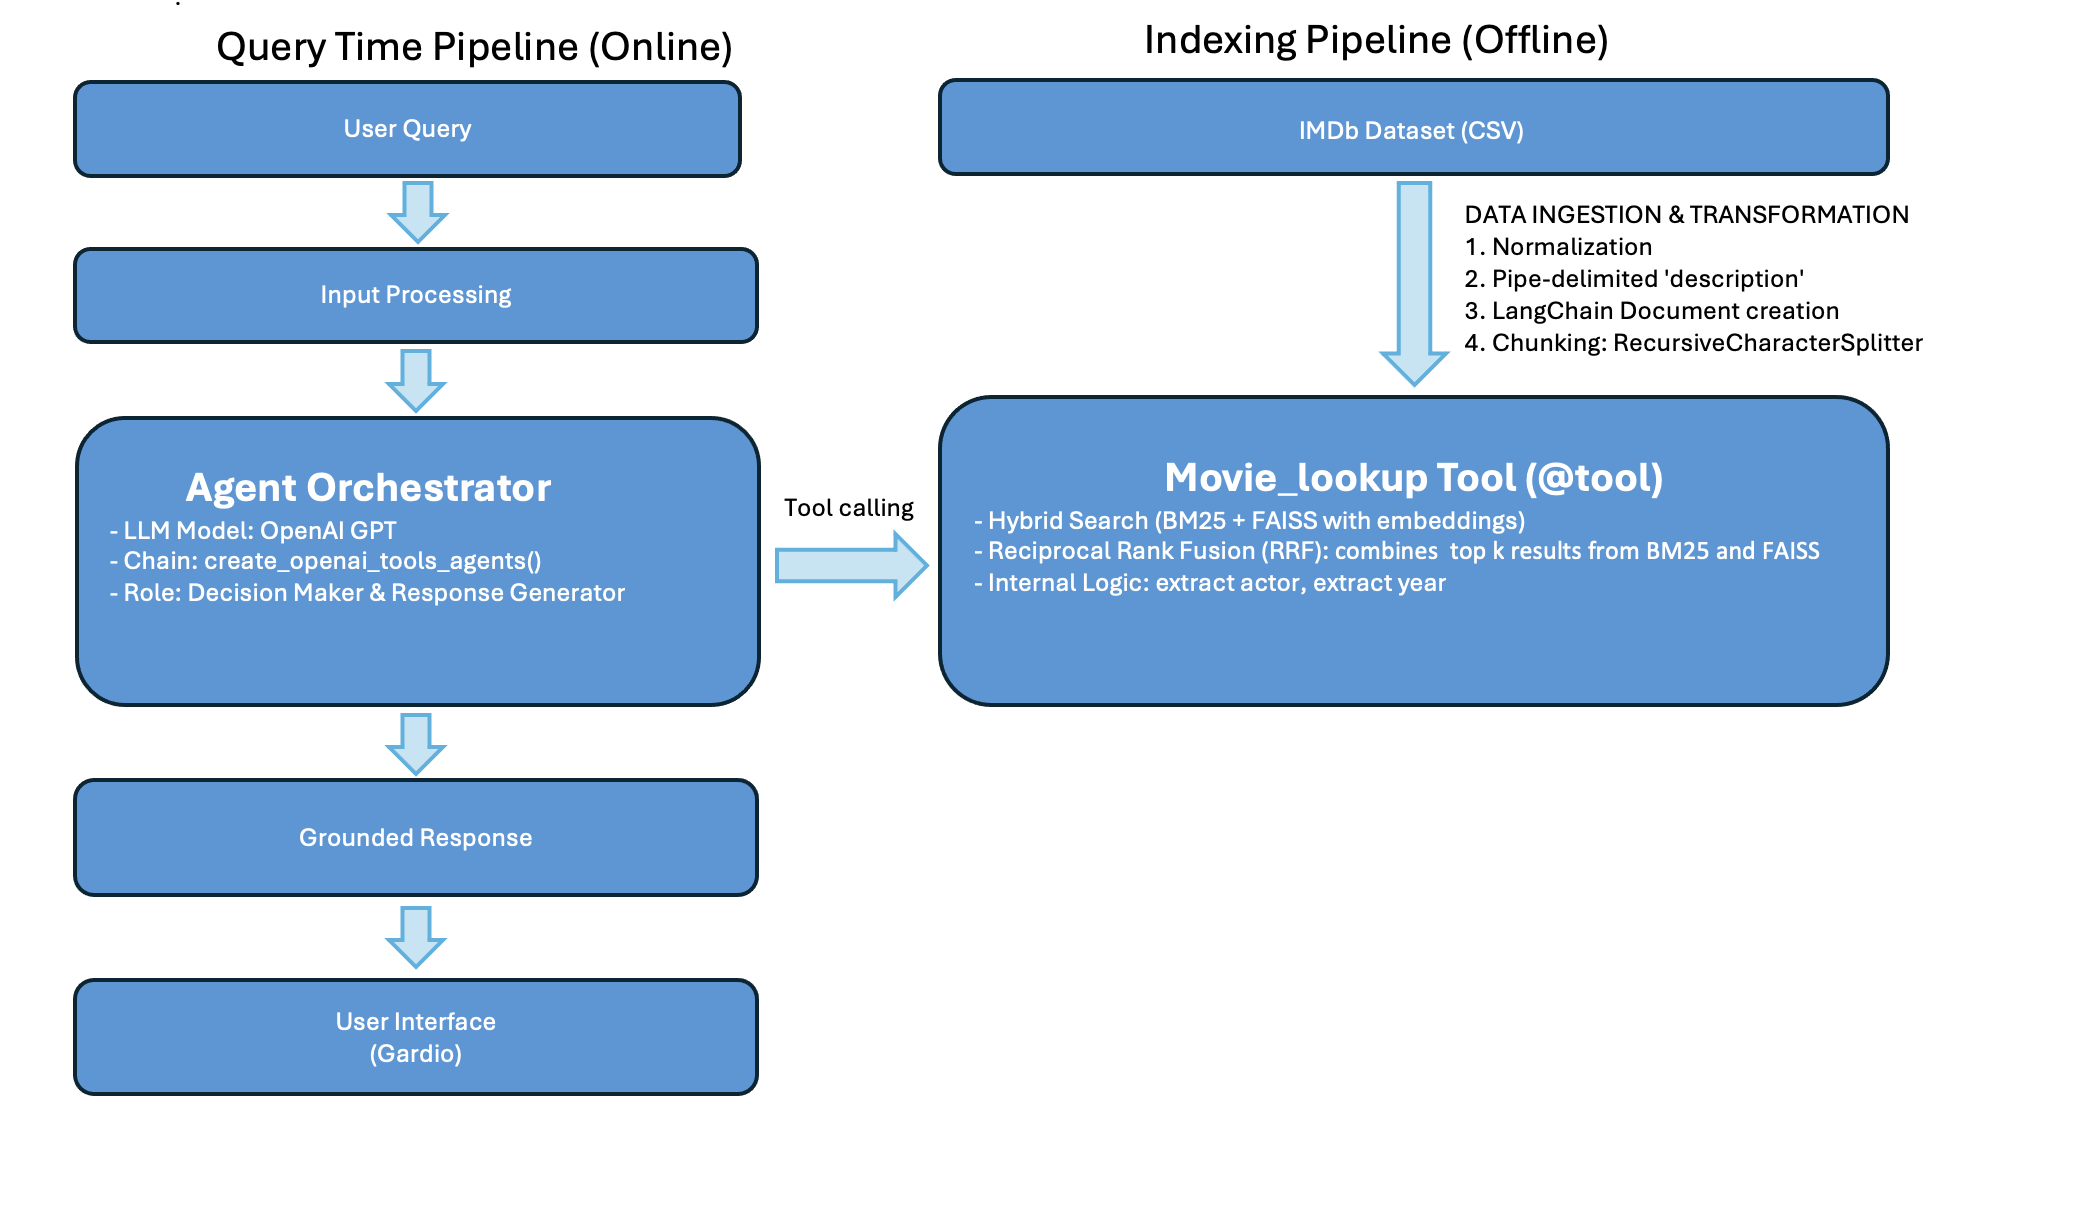




# **Technical Overview**

This notebook builds RAG-based LLM Movie Assistant designed to answer complex movie-related queries using a Large Language Model (LLM) and a local IMDb dataset. It leverages advanced Retrieval-Augmented Generation (RAG) techniques, agentic tool-calling, and structured data orchestration to provide grounded and reliable information.

This notebook implements following Architectures:

 - Architecture 1: Baseline Hybrid RAG Chain - A standard retrieval-augmented generation chain utilizing hybrid search.

- Architecture 2: Agentic orchestration (@tool + agent orchestration)

- Architecture 3: RAG Pipeline or Pipeline-Driven orchestration - A structured, linear execution flow for complex data processing.

- Architecture 4: LLM + chatbot - A direct LLM-to-chatbot interface for general queries.


## **Data Ingestion and Transformation**

Data Ingestion and Transformation is shared across all the architectures, this includes below steps.

1. ### **Data Preprocessing**
    - Normalization: Raw data is normalized into a standardized format, resolving naming inconsistencies.

    - Structured Context Construction: For each movie, it creates a description field that combines multiple data points like title, year, genre, director, cast, IMDb rating, metascore, and certificate into a single pipe-delimited string. This format is designed to be highly "retrieval-friendly".

    - Document Objects: Every movie row is converted into a LangChain Document object. The page_content is the pipe-delimited description, while the original movie attributes are preserved as rich metadata (e.g., duration, director, ratings).

2. ### **Advanced Chunking Strategy**

    - Splitter: It utilizes the RecursiveCharacterTextSplitter.

    - Configuration: The system is configured with a chunk size of 300 and a chunk overlap of 50.

    - Purpose: This specific configuration is used to maximize retriever recall and ensure that relevant context is not lost during the retrieval phase, while also preventing "context bloat" in the prompt.

3. ### **The Indexing Step: Dual-Engine Construction**

    All versions of the assistant rely on a HybridRetriever, which is a custom subclass of the LangChain BaseRetriever.
    
    It performs two types of search in parallel:
     
    i. Lexical Search (BM25)

    ii. Semantic Search (Embedding + FAISS)
    
    And finally Reciprocal Rank Fusion (RRF) combines the results from BM25 and FAISS to produce a single, optimized list of relevant documents.
    
    
    In Detail:
    
    - **Lexical Search (BM25)**: A keyword-based ranking retriever configured to return the top 200 results based on exact or partial word matches.

      It operates through two distinct technical phases: offline document indexing and online query retrieval.

        i. *Offline Document Indexing:*

        BM25 Inverted Index Construction: Each document segment(chunk) is passed to the BM25Retriever. This constructs an inverted index - a data structure that maps every unique word (term) in the movie descriptions to the specific chunks where they appear. This enables near-instant lookups for specific keywords.

        ii. *Online Query Retrieval*:

        When a user submits a query, the BM25 component executes the following lexical search process:

        Term Matching and Scoring: The raw text of the user's query is analyzed to identify individual keywords. The BM25 algorithm then scans its inverted index to find movie chunks containing those terms.

        Statistical Ranking: BM25 ranks these chunks by calculating a score for each, based on:

        Term Frequency (TF): How often a query keyword appears in a specific movie chunk.

        Inverse Document Frequency (IDF): Penalizing common words (like "the" or "movie") and rewarding rare, highly descriptive words (like "Inception" or "DiCaprio").

        Top-K Retrieval: The retriever identifies the top-k (k=200) lexical results based on these scores.

    - **Semantic Search (Embedding + FAISS):**
    The semantic search component follows a rigorous two-stage process—offline indexing and online retrieval—to enable high-precision movie discovery based on conceptual similarity.

        i. *Offline Data Indexing*:

        Vectorization: Each document segment(chunk)is processed through the OpenAIEmbeddings model, transforming human-readable text into vectors or embeddings.
            
        These embeddings are stored in a FAISS (Facebook AI Similarity Search) vector index alongside their associated metadata. This creates a spatial mapping where semantically related movies are clustered based on their vector coordinates.

        ii. *Online Query Retrieval*:

        Upon receiving a user request, the following operations are executed:

        Query Embedding: The input query is processed by the same OpenAIEmbeddings model to ensure compatibility with the indexed data.

        Similarity Search: The generated query vector is compared against the FAISS index to perform a Nearest Neighbor Search, identifying the top-k (k=200) most relevant text chunks.


      This semantic search works in parallel with lexical ranking (BM25), feeding into a Reciprocal Rank Fusion (RRF) to finalize the context for the grounded generation chain.


4. **Hybrid Retrival i.e Reciprocal Rank Fusion (RRF)**

    - The Reciprocal Rank Fusion combines the results from BM25 and FAISS to produce a single, optimized list of relevant documents.

    - Mechanism: It merges the two ranked lists using Reciprocal Rank Fusion with a "kappa-style" smoothing term.

    - Outcome: RRF gives higher priority to documents that appear at the top of both lists or very high in one of them, resulting in a single, optimized set of "top-k" fused documents for the LLM to process. The core of RRF is captured in its formula:
    
    
    RRF(d) = Σ(r ∈ R) 1 / (k + r(d))
    Where:
    - d is a document
    - R is the set of rankers (retrievers)
    - k is a constant
    - r(d) is the rank of document d in ranker r

5. **Grounded Generation (Shared Prompting Logic)**

    - Prompt Constraints: The final generation chain (usually create_stuff_documents_chain) is shared across architectures and uses strict prompt engineering to ensure grounding.

    - Guardrails: The model is explicitly instructed to use ONLY the provided context, list ONLY movies that appear in that context, and to not add any outside knowledge.


#Core Technical Architectures

The system implements four distinct versions of the assistant to demonstrate different orchestration patterns:

## Architecture 1: Baseline Hybrid RAG Chain

This version focuses on high-precision grounded generation by combining multiple retrieval methods.

Retrieval Stack: Utilizes a custom HybridRetriever that merges results from BM25 (lexical keyword ranking) and FAISS (semantic vector search).

Rank Fusion: The results from both retrievers are merged using Reciprocal Rank Fusion (RRF) to optimize recall and ranking robustness.

Generation Guardrails: Employs strict "context-only" prompting, instructing the LLM to use only the provided context and avoid outside knowledge to prevent hallucinations.

## Architecture 2: Agentic orchestration (@tool + agent orchestration)

This version transforms retrieval into a tool for an LLM agent.

Agentic Orchestration: An LLM acts as a controller, invoking a specialized movie_lookup tool for structured queries (e.g., actor or year range).

Structured Filtering: The tool performs deterministic filtering and deduplication based on movie metadata (cast and release year) before returning results to the agent.

## Architecture 3: RAG Pipeline or Pipeline-Driven orchestration

Designed for deterministic data analytics, this version follows a fixed workflow (DAG-style) rather than an agentic one.

Deterministic Workflow: Executes a fixed sequence:

  step 1: Extract (CSV loading)

  step 2: Analyze (computing insights like highest-rated)
  
  step 3: Recommend (filtering by genre/rating)

  step 4: Format

Multi-Step Analytics: Uses pandas for precise computations, such as finding the movie with the longest runtime.

## Architecture 4: LLM + Chatbot (This is when no context data is provided)

A control version using ChatOpenAI without any retrieval grounding or tool access, used to compare the benefits of the RAG and agentic approaches against standard LLM generation.


# Deployment

Includes interactive web interfaces for each version built using Gradio for all the architecture.


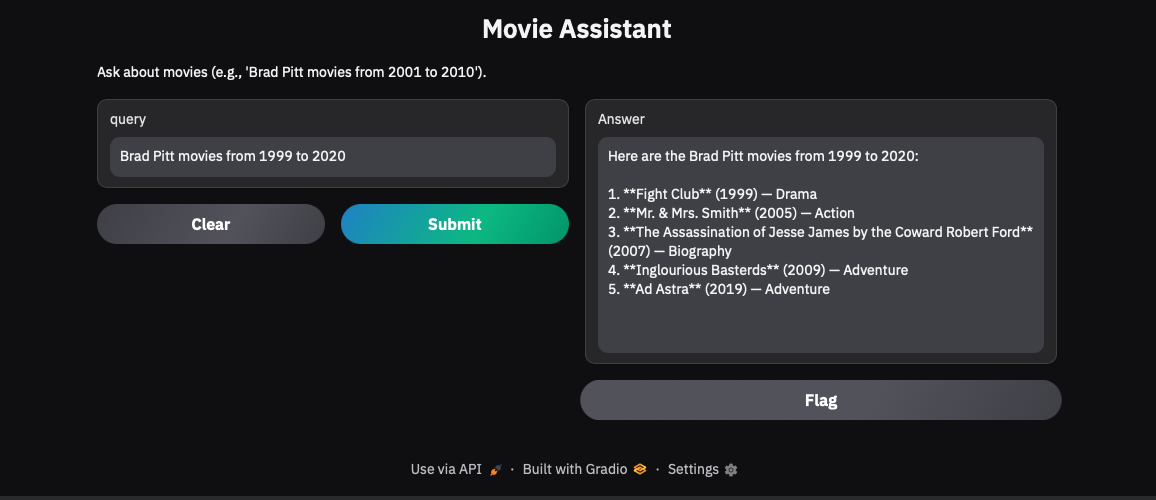

In [ ]:
# Importing the OpenAI library to interact with OpenAI's API services.
from openai import OpenAI

# Import basic libraries
import numpy as np
import pandas as pd

In [ ]:
import os
import getpass


OPENAI_API_KEY = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [ ]:
# This sets the OpenAI API key as an environment variable.
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [ ]:
# Creating an instance of the OpenAI client using the provided API key.
client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
!pip install -U langchain langchain-core langchain-community langchain-openai langchain-classic faiss-cpu

In [ ]:
!pip install langchain langchain-core langchain-community langchain-openai langchain-classic faiss-cpu

In [ ]:
!pip install -U langchain-text-splitters

In [ ]:
#Installing the libraries
!pip install -q rank_bm25      # BM25 keyword search engine (lexical retrieval / exact keyword matching)
!pip install -q faiss-cpu      # FAISS vector index for fast semantic similarity search

#Standard Python utilities
import os
import re
from collections import defaultdict
from typing import List, Any
import pandas as pd

#LangChain core: data containers + base interfaces
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever     # Base class to build custom retrievers (HybridRetriever)

#LangChain core: prompting + output formatting
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

#LangChain community: retrieval implementations + vector stores
from langchain_community.retrievers import BM25Retriever  # keyword-based retriever (good for names/years/exact terms)
from langchain_community.vectorstores import FAISS         # vector store/index for semantic similarity search

#OpenAI integrations for LangChain
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

#Text chunking
from langchain_text_splitters import RecursiveCharacterTextSplitter


#Optional "classic" chain helpers (older LangChain chain constructors)
from langchain_classic.chains.combine_documents import create_stuff_documents_chain
#Takes retrieved Documents, stuffs them into {context}, and asks the LLM to answer using that context.

#Older code needed this- updated RAG to use modern setups i.e LCEL instead of create_retrieval_chain. I won't need create_retrieval_chain in newer version.
#from langchain_classic.chains import create_retrieval_chain


Above triton warning warning can be safely ignored. This warning occurs because the Colab runtime is set to CPU, which prevents Triton from initializing. This is expected behavior; the system will automatically fall back to standard PyTorch kernels, ensuring full functionality on CPU instances

In [ ]:


#1. Data cleaning for star cast as they are glued with other's last name
df = pd.read_csv("IMDb_Dataset.csv")
def clean_cast(raw_cast: str) -> str:
    # Inserting comma before any capital letter that follows a lowercase letter
    return re.sub(r'(?<=[a-z])(?=[A-Z])', ', ', raw_cast)

df['Star Cast'] = df['Star Cast'].apply(clean_cast)

# normalize column names to make it lower case, remove spaces, tab, newline using strip() and remove special character with _
df.columns = (
    df.columns.str.lower()
              .str.strip()
              .str.replace(r"[()]", "", regex=True)
              .str.replace(r"[\s\-]+", "_", regex=True)
)

df.head()

,title,imdb_rating,year,certificates,genre,director,star_cast,metascore,poster_src,duration_minutes
0,End of the Spear,6.8,2005,PG-13,Adventure,Jim Hanon,"Louie Leonardo, Chad Allen, Jack Guzman",45.0,https://m.media-amazon.com/images/M/MV5BMTYxOT...,108.0
1,Elvira Madigan,7.0,1967,PG,Biography,Bo Widerberg,"Pia Degermark, Thommy Berggren, Lennart Malmer",66.0,https://m.media-amazon.com/images/M/MV5BMmY2Nj...,91.0
2,The Kid Stays in the Picture,7.3,2002,R,Documentary,Nanette Burstein,"Robert Evans, Eddie Albert, Peter Bart",75.0,https://m.media-amazon.com/images/M/MV5BZjhiZm...,93.0
3,It Ain't Over,8.2,2022,PG,Documentary,Sean Mullin,"Andy Andres, Roger Angell, Marty Appel",79.0,https://m.media-amazon.com/images/M/MV5BZWViYW...,99.0
4,Mahler,7.0,1974,PG,Biography,Ken Russell,"Robert Powell, Georgina Hale, Lee Montague",66.0,https://m.media-amazon.com/images/M/MV5BYzY4Mz...,115.0


In [ ]:


# 2. Build and Clean the Description string
def build_description(r):
    parts = [
        r["title"],
        f"year: {int(r['year'])}",
        f"genre: {r['genre']}",
        f"director: {r['director']}",
        f"cast: {r['star_cast']}",
        f"imdb: {r['imdb_rating']:.1f}" if pd.notna(r["imdb_rating"]) else None,
        f"metascore: {int(r['metascore'])}" if pd.notna(r["metascore"]) else None,
        f"cert: {r['certificates']}" if r.get("certificates") else None,
    ]
    return " | ".join([p for p in parts if p])

df["description"] = df.apply(build_description, axis=1)
df.head()
df.to_csv("movies_clean.csv", index=False)
from google.colab import files
#files.download("movies_clean.csv")


In [ ]:
# 3. Split each Document into smaller chunks

# i. Initialize a splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,     # max characters/tokens per chunk
    chunk_overlap=50,   # overlap for context continuity
    separators=["\n\n", "\n", ". ", " "]  # preferred break points
)
# ii. Build the doc for LangChain’s retrievers (BM25, FAISS, hybrid)

docs = [
    Document(
        page_content=row["description"], # main searchable text. This is the core text that will get embedded into FAISS and/or used in BM25.
        metadata={                       # structured fields for filtering/context METADATA is created here most important
            "title": row["title"],
            "year": int(row["year"]),
            "imdb_rating": float(row["imdb_rating"]),
            "metascore": float(row["metascore"]),
            "certificates": row["certificates"],
            "genre": row["genre"],
            "director": row["director"],
            "poster_src": row["poster_src"],
            "duration_minutes": float(row["duration_minutes"]),
            "star_cast": row["star_cast"],
        },
    )
    for _, row in df.iterrows() # loop over rows of the DataFrame
]


#iii. Apply to textsplitter to  doc
chunked_docs = text_splitter.split_documents(docs)


In [ ]:
# 3. Create retrievers

#Using the chunked_docs
#i. BM25: for Lexical (exact keyword) match (does not capture not semantic)
bm25 = BM25Retriever.from_documents(chunked_docs); bm25.k = 200


#ii. FAISS: This captures semantic similarity
emb = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
faiss = FAISS.from_documents(chunked_docs, emb)
faiss_retriever = faiss.as_retriever(search_kwargs={"k": 200})

#iii. Reciprocal Rank Fusion Function
def rrf_fuse(results_lists, k=50, kappa=10):
    scores, pick = defaultdict(float), {}
    for lst in results_lists:
        for rank, d in enumerate(lst, 1):
            key = (d.metadata["title"], d.metadata["year"])
            scores[key] += 1.0/(kappa+rank)
            pick.setdefault(key, d)
    return [pick[k] for k,_ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]






In [ ]:
# Hybrid retrival
# create hybrid retriever based on RRF function above to get retriever so it can be used in langchain
# Best Match 25 (BM25): returns a ranked list of keyword-based (lexical) matches.”
# FAISS: get a ranked list of semantic matches
# Fuse them via RRF.
# Return the hybrid list of top documents.
from collections import defaultdict
from typing import List, Any
from pydantic import Field
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document

class HybridRetriever(BaseRetriever):
    bm25: Any = Field(...)
    faiss_retriever: Any = Field(...)
    k: int = 50

    def _call_retriever(self, retriever: Any, query: str) -> List[Document]:
        if hasattr(retriever, "invoke"):
            return retriever.invoke(query)
        return retriever.get_relevant_documents(query)  # fallback for older retrievers

    def _get_relevant_documents(self, query: str, *, run_manager=None) -> List[Document]:
        bm25_hits = self._call_retriever(self.bm25, query)
        faiss_hits = self._call_retriever(self.faiss_retriever, query)
        return rrf_fuse([bm25_hits, faiss_hits], k=self.k)

#actual hybrid retriver
hybrid_retriever = HybridRetriever(bm25=bm25, faiss_retriever=faiss_retriever, k=50)



In [ ]:
#Define the tool (movie_lookup) to extract year and actor if it exist in query
import re
from langchain_core.tools import tool


def extract_actor(q: str) -> str | None:
    m = re.search(r"\b([A-Z][a-z]+ [A-Z][a-z]+)\b", q)
    return m.group(1) if m else None

def extract_year_range(q: str):
    yrs = list(map(int, re.findall(r"\b(19\d{2}|20\d{2})\b", q)))
    return (min(yrs), max(yrs)) if len(yrs) >= 2 else (None, None)


@tool
def movie_lookup(query: str) -> str:
    """Look up movies from the local dataset based on actor names and year range."""
    y0, y1 = extract_year_range(query)
    actor = extract_actor(query)

    if not actor:
        return "Could not detect an actor name (e.g., 'Brad Pitt')."

    filtered = [
        d for d in docs
        if actor.lower() in str(d.metadata.get("star_cast", "")).lower()
        and (y0 is None or (y0 <= d.metadata["year"] <= y1))
    ]

    # dedupe + sort
    seen = set()
    rows = []
    for d in sorted(filtered, key=lambda x: (x.metadata["year"], x.metadata["title"])):
        key = (d.metadata["title"], d.metadata["year"])
        if key in seen:
            continue
        seen.add(key)
        rows.append(f"- {d.metadata['title']} ({d.metadata['year']}) — {d.metadata.get('genre','')}")
    return "\n".join(rows) if rows else "No matches found in dataset."


In [ ]:
# Initializing the ChatOpenAI model to interact with OpenAI's GPT model.
llm = ChatOpenAI(api_key=os.environ["OPENAI_API_KEY"], model = 'gpt-4o-mini')

In [ ]:

# Architecture 1: Baseline RAG Chain

from langchain_core.runnables import RunnablePassthrough

from pydantic import Field

# Build RAG chain

llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model='gpt-4o-mini')

prompt = ChatPromptTemplate.from_template(
"""You are a movie assistant. Use ONLY the context below.

<context>
{context}
</context>

Question: {input}

Instructions:
- List ONLY movies that appear in the context.
- Do NOT add outside knowledge.
- Respect the requested year range.

Answer:""")

document_chain = create_stuff_documents_chain(llm, prompt)

rag_chain = (
    {"context": hybrid_retriever, "input": RunnablePassthrough()}
    | document_chain
)

q = "Brad Pitt movies"
print(rag_chain.invoke(q))

#making a function to be able to use in gardio or just to print
def answer(query: str) -> str:
    try:
        return rag_chain.invoke(query)
    except Exception as e:
        return f"Error: {e}"


1. Seven Years in Tibet | year: 1997 | genre: Adventure | director: Jean-Jacques Annaud | imdb: 7.1 | metascore: 55 | cert: PG-13
2. Inglourious Basterds | year: 2009 | genre: Adventure | director: Quentin Tarantino | imdb: 8.4 | metascore: 69 | cert: R
3. Ad Astra | year: 2019 | genre: Adventure | director: James Gray | imdb: 6.5 | metascore: 80 | cert: PG-13
4. Babylon | year: 2022 | genre: Comedy | director: Damien Chazelle | imdb: 7.1 | metascore: 61 | cert: R
5. Bullet Train | year: 2022 | genre: Action | director: David Leitch | imdb: 7.3 | metascore: 49 | cert: R
6. Fight Club | year: 1999 | genre: Drama | director: David Fincher | imdb: 8.8 | metascore: 67 | cert: R
7. Moneyball | year: 2011 | genre: Biography | director: Bennett Miller | imdb: 7.6 | metascore: 87 | cert: PG-13
8. The Assassination of Jesse James by the Coward Robert Ford | year: 2007 | genre: Biography | director: Andrew Dominik | imdb: 7.5 | metascore: 68 | cert: R
9. Se7en | year: 1995 | genre: Crime | direc

In [ ]:
def final_response(user_query: str) -> str:
    return rag_chain.invoke(user_query)

In [ ]:
!pip install Gradio

In [ ]:
import gradio as gr

# Creating the Gradio interface for the product recommendation system
app = gr.Interface(
    fn=answer,        # The function that processes user input and returns recommendations, created earlier
    inputs=gr.Textbox(lines=2, placeholder="Ask a question..."),
    outputs=gr.Textbox(lines=20, label="Answer"),
    title="Movie Bot",
    description="Type your question below to get the recommendations",
    theme="Ocean",
    flagging_mode="never"
)

# Launching the Gradio app to start the interface and make it accessible via web browser
app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8404d6727107c710a9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Architecture 2: Agentic orchestration (@tool + agent orchestration)
import re
from langchain_core.tools import tool
from langchain.agents import create_agent


def extract_actor(q: str) -> str | None:
    m = re.search(r"\b([A-Z][a-z]+ [A-Z][a-z]+)\b", q)
    return m.group(1) if m else None

def extract_year_range(q: str):
    yrs = list(map(int, re.findall(r"\b(19\d{2}|20\d{2})\b", q)))
    return (min(yrs), max(yrs)) if len(yrs) >= 2 else (None, None)


@tool
def movie_lookup(query: str) -> str:
    """Look up movies from the local dataset based on actor names and year range."""
    y0, y1 = extract_year_range(query)
    actor = extract_actor(query)

    if not actor:
        return "Could not detect an actor name (e.g., 'Brad Pitt')."

    filtered = [
        d for d in docs
        if actor.lower() in str(d.metadata.get("star_cast", "")).lower()
        and (y0 is None or (y0 <= d.metadata["year"] <= y1))
    ]

    # dedupe + sort
    seen = set()
    rows = []
    for d in sorted(filtered, key=lambda x: (x.metadata["year"], x.metadata["title"])):
        key = (d.metadata["title"], d.metadata["year"])
        if key in seen:
            continue
        seen.add(key)
        rows.append(f"- {d.metadata['title']} ({d.metadata['year']}) — {d.metadata.get('genre','')}")
    return "\n".join(rows) if rows else "No matches found in dataset."

# create the agent
agent = create_agent(
    model=llm,
    tools=[movie_lookup],
    system_prompt=(
        "You are a movie assistant. Use ONLY the tool output. "
        "For any movie question, call movie_lookup."
    ),
)

#Invoke the agent
q = "List all Brad Pitt movies from 2002 to 2008."
out = agent.invoke({"messages": [{"role": "user", "content": q}]})
print(out["messages"][-1].content)


Here are the Brad Pitt movies from 2002 to 2008:

1. **Mr. & Mrs. Smith** (2005) — Action
2. **The Assassination of Jesse James by the Coward Robert Ford** (2007) — Biography


In [ ]:
# Architecture 2 continues - Agentic orchestration (@tool + agent orchestration) with Gardio App to create web user interface

import gradio as gr # Import gradio

# Wrap retrieval chain in a tool

def run_agent(query: str) -> str:
    out = agent.invoke({"messages": [{"role": "user", "content": query}]})
    return out["messages"][-1].content

# 4. Launch the Gradio interface
demo_gardio_new = gr.Interface(
    fn=run_agent,
    inputs="text",
    outputs=gr.Textbox(lines=10, label="Answer"),
    title="Movie Assistant",
    theme="Ocean",
    description="Ask about movies (e.g., 'Brad Pitt movies from 2001 to 2010')."
)

# Remember to define llm outside the function for the app to run
if __name__ == "__main__":
    demo_gardio_new.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5dafce6d6be11ba2b3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:

# Architecture 3: RAG Pipeline or Pipeline-Driven orchestration

''' Below is RAG Pipeline which has following steps:
extract → analyze → recommend → format
and return the answer
'''

import pandas as pd
from langchain_core.tools import tool
import re

@tool
def extract_movie_data() -> list[dict]:
    """Extracts and loads movie data into JSON-serializable records."""
    df = pd.read_csv("IMDb_Dataset.csv")
    return df.to_dict(orient="records")

@tool
def analyze_movies(data: list[dict]) -> dict:
    """Analyzes movies to find the highest-rated and longest movie."""
    df = pd.DataFrame(data)
    highest_rated = df.loc[df["IMDb Rating"].idxmax()]


    longest_movie = df.loc[df["Duration (minutes)"].idxmax()]
    return {
        "Highest Rated Movie": highest_rated["Title"],
        "Rating": float(highest_rated["IMDb Rating"]),
        "Longest Movie": longest_movie["Title"],
        "Duration": float(longest_movie["Duration (minutes)"]),
    }


@tool
def recommend_movies(data: list[dict], genre: str, min_rating: float) -> list[dict]:
    """Recommends movies based on genre and IMDb rating."""
    df = pd.DataFrame(data)
    rec = df[
        df["Genre"].str.contains(genre, case=False, na=False)
        & (df["IMDb Rating"] >= min_rating)
    ]
    return rec[["Title", "IMDb Rating", "Year"]].to_dict(orient="records")

@tool
def format_metadata(movie: dict) -> str:
    """Formats movie metadata for better presentation."""
    return (f"Movie: {movie['Title']}\n"
            f"Year: {movie['Year']}\n"
            f"IMDb Rating: {movie['IMDb Rating']}\n"
            f"Genre: {movie['Genre']}\n"
            f"Director: {movie.get('Director','')}\n"
            f"Duration: {movie.get('Duration (minutes)','')} minutes\n"
            f"MetaScore: {movie.get('MetaScore','')}\n")

def extract_actor(q: str) -> str | None:
    m = re.search(r"\b([A-Z][a-z]+ [A-Z][a-z]+)\b", q)
    return m.group(1) if m else None

def extract_year_range(q: str):
    yrs = list(map(int, re.findall(r"\b(19\d{2}|20\d{2})\b", q)))
    return (min(yrs), max(yrs)) if len(yrs) >= 2 else (None, None)

@tool
def movie_lookup(query: str) -> str:
    """Look up movies from the local dataset based on actor names and year range."""
    query = query.strip()
    if not query:
        return "Please enter a question (e.g., 'Brad Pitt movies 2005 to 2009')."

    y0, y1 = extract_year_range(query)
    actor = extract_actor(query)

    if actor:
        filtered = [
            d for d in docs
            if actor.lower() in str(d.metadata.get("star_cast", "")).lower()
            and (y0 is None or (y0 <= d.metadata["year"] <= y1))
        ]
        context_docs = filtered if filtered else hybrid_retriever.invoke(query)
    else:
        # if no actor -> just retrieve
        context_docs = hybrid_retriever.invoke(query)

    return document_chain.invoke({"input": query, "context": context_docs})


def orchestrate_movie_analysis():
    # Step 1: Extract movie data
    movie_data = extract_movie_data.invoke({})

    # Step 2: Perform analysis
    # Call analyze_movies with tool_input containing the DataFrame as a value
    analysis_results = analyze_movies.invoke({"data": movie_data})

    # Step 3: Recommend movies based on user input
    genre_input = "Documentary"
    min_rating_input = 7.0
    recommendations = recommend_movies.invoke(
        {"data": movie_data, "genre": genre_input, "min_rating": min_rating_input}
    )

    if recommendations:
        title = recommendations[0]["Title"]
        full_movie_data = next(m for m in movie_data if m["Title"] == title)
        formatted_output = format_metadata.invoke({"movie": full_movie_data})
    else:
        formatted_output = "No recommendations found."

    return {
        "Analysis Results": analysis_results,
        "Recommendations": recommendations,
        "Formatted Metadata": formatted_output
    }

output = orchestrate_movie_analysis()
print(output)


{'Analysis Results': {'Highest Rated Movie': "Marty's Project", 'Rating': 9.5, 'Longest Movie': '1900', 'Duration': 317.0}, 'Recommendations': [{'Title': 'The Kid Stays in the Picture', 'IMDb Rating': 7.3, 'Year': 2002}, {'Title': "It Ain't Over", 'IMDb Rating': 8.2, 'Year': 2022}, {'Title': 'Stephen Curry: Underrated', 'IMDb Rating': 7.3, 'Year': 2023}, {'Title': 'The King of Kong: A Fistful of Quarters', 'IMDb Rating': 8.0, 'Year': 2007}, {'Title': 'Muscle Shoals', 'IMDb Rating': 7.8, 'Year': 2013}, {'Title': 'McQueen', 'IMDb Rating': 7.7, 'Year': 2018}, {'Title': '20 Feet from Stardom', 'IMDb Rating': 7.4, 'Year': 2013}, {'Title': 'The Look of Silence', 'IMDb Rating': 8.3, 'Year': 2014}, {'Title': 'The Sparks Brothers', 'IMDb Rating': 7.7, 'Year': 2021}, {'Title': 'Val', 'IMDb Rating': 7.6, 'Year': 2021}, {'Title': 'Marley', 'IMDb Rating': 7.9, 'Year': 2012}, {'Title': 'The Pigeon Tunnel', 'IMDb Rating': 7.0, 'Year': 2023}, {'Title': "Won't You Be My Neighbor?", 'IMDb Rating': 8.3, 

In [ ]:
# Architecture 4: LLM + chatbot (This is when no context data is provided)
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# Define OpenAI Agent Model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Fix: Explicitly enforce JSON output in the system prompt
prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are an AI assistant that helps users with movie recommendations and analysis. "
     "Always respond in valid JSON with clear keys. "
    ),
    ("user", "{input}")
])


# Define the Chain with JSON Parsing
parser = JsonOutputParser()

# Fix: Add a function to handle invalid JSON responses
def extract_text(output):
    """Ensures correct text extraction without JSON parsing failures."""
    try:
        if isinstance(output, dict) and "text" in output:
            return output["text"]
        return output  # If already a string, return as-is
    except Exception as e:
        return f"Error processing response: {str(e)}"

chain = prompt | llm | parser | RunnableLambda(extract_text)
chain = RunnablePassthrough().assign(output=chain)  # Assign processed output

# Function to Process User Queries
def process_query(user_query: str):
    response = chain.invoke({"input": user_query})
    return response

# Orchestrator Function
def orchestrate_movie_chat():
    print("Welcome to the Movie AI Assistant!")
    print("Type 'exit' to end the chat.")

    while True:
        user_query = input("\nAsk a movie-related question: ")
        if user_query.lower() == "exit":
            print("Goodbye!")
            break
        response = process_query(user_query)
        print("\nAI Response:\n", response.get("output", "No response received."))  # Handle missing keys

# Run the chatbot
orchestrate_movie_chat()


Welcome to the Movie AI Assistant!
Type 'exit' to end the chat.

Ask a movie-related question: tom cruise movies

AI Response:
 {'Tom_Cruise_Movies': [{'title': 'Top Gun', 'release_year': 1986, 'genre': 'Action, Drama', 'description': "A young naval aviator competes to be the best in his class at the Navy's elite fighter weapons school."}, {'title': 'Jerry Maguire', 'release_year': 1996, 'genre': 'Comedy, Drama, Romance', 'description': 'A sports agent has a moral crisis and starts his own agency with a single football player.'}, {'title': 'Mission: Impossible', 'release_year': 1996, 'genre': 'Action, Adventure, Thriller', 'description': 'A secret agent is framed for the deaths of his espionage team and must uncover the real spy.'}, {'title': 'Rain Man', 'release_year': 1988, 'genre': 'Drama', 'description': 'A self-centered man discovers that his estranged brother is an autistic savant and takes him on a cross-country trip.'}, {'title': 'Minority Report', 'release_year': 2002, 'genre'

In [ ]:
#Architecture - 4 with Gardio [i.e LLM + Gardio (When no context provided)]
import gradio as gr
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# Define OpenAI Agent Model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

#  Fix: Explicitly enforce JSON output in the system prompt
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an AI assistant that helps users with movie recommendations and analysis. "
               "Always respond in valid JSON format with the key 'recommendations', which should be a list of "
               "movie dictionaries containing 'title', 'year', 'genre', and 'description'."),
    ("user", "{input}")
])

# Define the Chain with JSON Parsing
parser = JsonOutputParser()

# Function to format AI response for clean UI output
def format_recommendations(response):
    """Formats AI response for structured movie recommendations."""
    try:
        if isinstance(response, dict) and "recommendations" in response:
            recommendations = response["recommendations"]
            output_text = "Recommended Movies\n\n"
            for movie in recommendations:
                output_text += f" {movie['title']} ({movie['year']})\n"
                output_text += f" Genre: {movie['genre']}\n"
                output_text += f" Plot: {movie['description']}\n\n"
            return output_text.strip()
        return " No recommendations found. Try a different query!"
    except Exception as e:
        return f" Error processing response: {str(e)}"

#  Fix: Extract & format JSON correctly
chain = prompt | llm | parser | RunnableLambda(format_recommendations)
chain = RunnablePassthrough().assign(output=chain)  # Assign processed output

# Function to Process User Queries
def final_response(user_query: str):
    response = chain.invoke({"input": user_query})
    return response.get("output", "No response received.")

#  Simple Gradio UI with Theming
app = gr.Interface(
    fn=final_response,
    inputs="text",
    outputs="markdown",
    title="Movie Recommendation Bot",
    description="Type your question below to get AI-powered movie recommendations!",
    theme="soft"
)

#  Launching the Gradio app
app.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fd963539c4931dffc8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
